In [34]:
# Cell 1
import os
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from PIL import Image
import mediapipe as mp

# Konfigurasi — sesuaikan path dan parameter
VIDEO_DIRS = ["./train/drowsiness_separated/", "./train/non-drowsiness_separated/"]
OUTPUT_DIRS = ["./mp_output/drowsiness_faces/", "./mp_output/non-drowsiness_faces/"]

NUM_FRAMES_TOTAL = 60
OUT_SIZE = (224, 224)
MARGIN = 0.35
MIN_CONFIDENCE = 0.5

# Pastikan folder output ada
for d in OUTPUT_DIRS:
    os.makedirs(d, exist_ok=True)

mp_face = mp.solutions.face_detection
print("Ready. MediaPipe imported. OUTPUT_DIRS:", OUTPUT_DIRS)

Ready. MediaPipe imported. OUTPUT_DIRS: ['./mp_output/drowsiness_faces/', './mp_output/non-drowsiness_faces/']


In [35]:
def sample_frame_indices(total, num):
    if total <= 0:
        return [0] * num
    idxs = np.linspace(0, max(total - 1, 0), num)
    return [int(round(i)) for i in idxs]


def expand_bbox(x, y, w, h, fw, fh, frac):
    dw, dh = int(w * frac), int(h * frac)
    x0 = max(0, x - dw)
    y0 = max(0, y - dh)
    x1 = min(fw, x + w + dw)
    y1 = min(fh, y + h + dh)
    return (int(x0), int(y0), int(x1 - x0), int(y1 - y0))


def crop_and_resize(frame_bgr, bbox, out_size):
    x, y, w, h = bbox
    x2, y2 = x + w, y + h
    hF, wF = frame_bgr.shape[:2]
    x, y = max(0, x), max(0, y)
    x2, y2 = min(wF, x2), min(hF, y2)
    crop = frame_bgr[y:y2, x:x2]
    if crop is None or crop.size == 0:
        # fallback center square
        s = min(hF, wF)
        cx, cy = wF // 2, hF // 2
        crop = frame_bgr[cy - s//2: cy + s//2, cx - s//2: cx + s//2]
        if crop is None or crop.size == 0:
            crop = np.zeros((out_size[1], out_size[0], 3), dtype=np.uint8)
            return crop
    return cv2.resize(crop, out_size)


def save_bgr_as_jpeg_with_pil(bgr_img, out_path, quality=95):
    rgb = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    pil = Image.fromarray(rgb)
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    pil.save(out_path, format="JPEG", quality=quality)


def safe_makedirs(path):
    if path:
        os.makedirs(path, exist_ok=True)

In [36]:
def extract_video_to_jpg_split_mediapipe(video_path, out_dir_a, out_dir_b,
                                         num_frames=NUM_FRAMES_TOTAL, out_size=OUT_SIZE,
                                         margin=MARGIN, min_conf=MIN_CONFIDENCE, debug=False):
    """
    Extract `num_frames` uniformly from video_path, save first half to out_dir_a and
    second half to out_dir_b. Returns (success: bool, logs: list[str]).
    """
    logs = []
    video_path = str(video_path)
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        logs.append(f"VIDEO_OPEN_FAIL: {video_path}")
        return False, logs

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames <= 0:
        # count by reading once
        cnt = 0
        while True:
            ret, _ = cap.read()
            if not ret:
                break
            cnt += 1
        total_frames = cnt
        cap.release()
        cap = cv2.VideoCapture(video_path)
        logs.append(f"COUNTED_FRAMES={total_frames}")
    else:
        logs.append(f"META_FRAMES={total_frames}")

    indices = sample_frame_indices(total_frames, num_frames)
    safe_makedirs(out_dir_a); safe_makedirs(out_dir_b)

    faces = [None] * num_frames
    idx_ptr = 0
    frame_idx = 0
    next_target = indices[idx_ptr] if indices else None
    prev_bbox = None

    with mp_face.FaceDetection(model_selection=1, min_detection_confidence=min_conf) as detector:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if next_target is not None and frame_idx == next_target:
                hF, wF = frame.shape[:2]
                rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                res = detector.process(rgb)
                dets = res.detections if res and res.detections else []

                bbox = None
                best_area = -1
                if dets:
                    for d in dets:
                        rbb = d.location_data.relative_bounding_box
                        xmin = rbb.xmin; ymin = rbb.ymin; ww = rbb.width; hh = rbb.height
                        x = int(max(0, xmin) * wF)
                        y = int(max(0, ymin) * hF)
                        w = max(2, int(max(0, ww) * wF))
                        h = max(2, int(max(0, hh) * hF))
                        area = w * h
                        if area > best_area:
                            best_area = area
                            bbox = (x, y, w, h)

                if bbox is None:
                    if prev_bbox is not None:
                        bbox = prev_bbox
                        if debug: logs.append(f"FRAME_{frame_idx}: using prev_bbox")
                    else:
                        s = min(hF, wF)
                        cx, cy = wF // 2, hF // 2
                        bbox = (cx - s//2, cy - s//2, s, s)
                        logs.append(f"FRAME_{frame_idx}: no_detection -> center")
                else:
                    logs.append(f"FRAME_{frame_idx}: detection_area={best_area}")

                bbox_exp = expand_bbox(*bbox, wF, hF, margin)
                face = crop_and_resize(frame, bbox_exp, out_size)
                faces[idx_ptr] = face
                prev_bbox = bbox_exp

                idx_ptr += 1
                if idx_ptr >= len(indices):
                    break
                next_target = indices[idx_ptr]

            frame_idx += 1

    cap.release()

    valid = [f for f in faces if f is not None]
    if not valid:
        logs.append("NO_VALID_FACES_COLLECTED")
        return False, logs

    last = None
    for i in range(len(faces)):
        if faces[i] is None:
            faces[i] = last.copy() if last is not None else valid[0].copy()
        else:
            last = faces[i]

    half = num_frames // 2
    for i, img in enumerate(faces, start=1):
        if i <= half:
            out_dir = out_dir_a
            file_no = i
        else:
            out_dir = out_dir_b
            file_no = i - half
        out_path = os.path.join(out_dir, f"{file_no:02d}.jpg")
        save_bgr_as_jpeg_with_pil(img, out_path)

    logs.append(f"SAVED_FRAMES={len(faces)} -> folders: {out_dir_a}, {out_dir_b}")
    return True, logs


def batch_process_to_jpg_split_mediapipe(video_dir, output_dir, label_csv=None):
    entries = []
    if label_csv is not None:
        df = pd.read_csv(label_csv)
        if "video_filename" in df.columns and "label" in df.columns:
            entries = list(zip(df.video_filename, df.label))
        else:
            entries = [(r.iloc[0], r.iloc[1]) for _, r in df.iterrows()]
    else:
        for fn in sorted(os.listdir(video_dir)):
            if fn.lower().endswith((".mp4",".avi",".mkv",".mov",".webm")):
                entries.append((fn, ""))

    results = []
    safe_makedirs(output_dir)
    for filename, label in tqdm(entries, desc="MP Extract"):
        in_path = os.path.join(video_dir, filename)
        folder_name = os.path.splitext(filename)[0]
        out_folder_a = os.path.join(output_dir, folder_name + "_05a")
        out_folder_b = os.path.join(output_dir, folder_name + "_05b")
        ok, logs = extract_video_to_jpg_split_mediapipe(in_path, out_folder_a, out_folder_b,
                                                        NUM_FRAMES_TOTAL, OUT_SIZE, MARGIN, MIN_CONFIDENCE, debug=False)
        results.append({
            "video": filename,
            "out_folder_a": out_folder_a,
            "out_folder_b": out_folder_b,
            "label": label,
            "success": bool(ok),
            "logs": "; ".join(logs)
        })
    df = pd.DataFrame(results)
    df.to_csv(os.path.join(output_dir, "manifest_mediapipe.csv"), index=False)
    return df

Processing: ./train/drowsiness_separated/ -> ./mp_output/drowsiness_faces/


MP Extract:   0%|          | 0/60 [00:00<?, ?it/s]

                             video  \
0  front_microsleep_subject_01.mp4   
1  front_microsleep_subject_02.mp4   
2  front_microsleep_subject_03.mp4   
3  front_microsleep_subject_04.mp4   
4  front_microsleep_subject_05.mp4   

                                        out_folder_a  \
0  ./mp_output/drowsiness_faces/front_microsleep_...   
1  ./mp_output/drowsiness_faces/front_microsleep_...   
2  ./mp_output/drowsiness_faces/front_microsleep_...   
3  ./mp_output/drowsiness_faces/front_microsleep_...   
4  ./mp_output/drowsiness_faces/front_microsleep_...   

                                        out_folder_b label  success  \
0  ./mp_output/drowsiness_faces/front_microsleep_...           True   
1  ./mp_output/drowsiness_faces/front_microsleep_...           True   
2  ./mp_output/drowsiness_faces/front_microsleep_...           True   
3  ./mp_output/drowsiness_faces/front_microsleep_...           True   
4  ./mp_output/drowsiness_faces/front_microsleep_...           True   

       

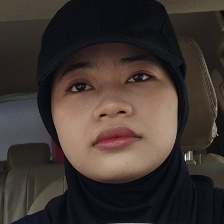

Processing: ./train/non-drowsiness_separated/ -> ./mp_output/non-drowsiness_faces/


MP Extract:   0%|          | 0/60 [00:00<?, ?it/s]

                        video  \
0  front_focus_subject_01.mp4   
1  front_focus_subject_02.mp4   
2  front_focus_subject_03.mp4   
3  front_focus_subject_04.mp4   
4  front_focus_subject_05.mp4   

                                        out_folder_a  \
0  ./mp_output/non-drowsiness_faces/front_focus_s...   
1  ./mp_output/non-drowsiness_faces/front_focus_s...   
2  ./mp_output/non-drowsiness_faces/front_focus_s...   
3  ./mp_output/non-drowsiness_faces/front_focus_s...   
4  ./mp_output/non-drowsiness_faces/front_focus_s...   

                                        out_folder_b label  success  \
0  ./mp_output/non-drowsiness_faces/front_focus_s...           True   
1  ./mp_output/non-drowsiness_faces/front_focus_s...           True   
2  ./mp_output/non-drowsiness_faces/front_focus_s...           True   
3  ./mp_output/non-drowsiness_faces/front_focus_s...           True   
4  ./mp_output/non-drowsiness_faces/front_focus_s...           True   

                                     

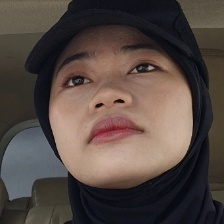

In [37]:
def inspect_image(path):
    if not os.path.exists(path):
        print("No file:", path); return
    print("FILE:", path, "size:", os.path.getsize(path))
    pil = Image.open(path)
    print("PIL mode:", pil.mode, "size:", pil.size)
    pil_rgb = pil.convert("RGB")
    arr = np.array(pil_rgb)
    for c,name in enumerate(["R","G","B"]):
        print(f" ch {name}: min={arr[...,c].min()} max={arr[...,c].max()} nonzero={np.count_nonzero(arr[...,c])}")
    display(pil_rgb)


for video_dir, output_dir in zip(VIDEO_DIRS, OUTPUT_DIRS):
    print("Processing:", video_dir, "->", output_dir)
    manifest = batch_process_to_jpg_split_mediapipe(video_dir, output_dir, label_csv=None)
    print(manifest.head())

    if len(manifest) > 0 and manifest.iloc[0].success:
        a_folder = manifest.iloc[0].out_folder_a
        sample_path = os.path.join(a_folder, "01.jpg") if os.path.exists(os.path.join(a_folder, "01.jpg")) else None
        if sample_path:
            inspect_image(sample_path)
        else:
            print("No sample image found in", a_folder)